In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
import ar1_approx as ar
import time
import bisect as bi
np.set_printoptions(threshold=np.inf)
%matplotlib inline

# Problem 2

### Parameters

In [2]:
# Set parameters
alpha_k = 0.297
alpha_l = 0.65
delta = 0.154
psi = 0.03
w = 0.7
r= 0.04
betafirm = (1/(1+r))
# Parameters regarding shock
sigma_eps = 0.213
mu = 0.0
rho = 0.7605
sizez = 9

### Capital Stock and Productivity Shocks

In [3]:
# Discretizing the space of capital stock 
dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
@jit
def create_K(numb,dens,delta,ub_k):
    for j in range(int(numb * dens)):
        K[j] = ub_k * (1 - delta) ** (j / dens)
    return K

K = create_K(numb,dens,delta,ub_k)
kvec = K[::-1]
sizek = kvec.shape[0]

# Find the Markov process for the shocks
z_grid, pi = ar.addacooper(sizez,mu,rho,sigma_eps)
z_grid = np.exp(z_grid) #make it to ln

### Cash Flow

In [4]:
# operating profits, op
@jit
def operating_profits(alpha_l,alpha_k,w,kvec,z_grid,sizez,sizek):
    op = np.zeros((sizek,sizez))
    for i in range(len(z_grid)):
        op[:,i] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
              (z_grid[i] ** (1 / (1 - alpha_l)))*((kvec ** alpha_k) ** (1 / (1 - alpha_l))))
    return op

# firm cash flow, e
@jit
def cash_flow_inv(psi,delta,kvec,op,sizek,sizez):
    e = np.zeros((sizek,sizek,sizez))
    for i in range(sizek):
        for j in range(sizek):
            for k in range(sizez):
                e[i,j,k] = (op[i,k] - kvec[j] + ((1 - delta) * kvec[i]) - psi*kvec[i])
    return e

### Value Function Iteration

In [5]:
def value_iteration(VFdist,VFtol,VFiter,VFmaxiter,V,Vmat1,Vmat2,sizek,sizez,pi,e,op,betafirm):
    start_time = time.clock()
    while VFdist > VFtol and VFiter < VFmaxiter:
        TV = np.copy(V)
        for i in range(sizek):  # loop over k
            for k in range(sizez): #loop over z
                if (i-dens)<0:
                    Vmat2[i,k] = op[i,k]+betafirm*(V[i,:]@pi[k,:])
                else:
                    Vmat2[i,k] = op[i,k]+betafirm*(V[i-dens,:]@pi[k,:])
                for j in range(sizek):  # loop over k'
                    Vmat1[i,j,k] = e[i,j,k] + betafirm * (V[j,:]@pi[k,:])
        maxes = np.array([Vmat1.max(axis=1),Vmat2])
        V = maxes.max(axis=0) #0=invest, 1=not invest
        INV = np.argmax(maxes,axis=0)
        PF = np.argmax(Vmat1,axis=1)
        VFdist = (np.absolute(V - TV)).max()  
        VFiter += 1
    VFI_time = time.clock() - start_time
    if VFiter < VFmaxiter:
        print('Value function converged after this many iterations:', VFiter)
    else:
        print('Value function did not converge')
    print('VFI took ', VFI_time, ' seconds to solve')
    return V, PF, INV

In [6]:
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 500
V = np.zeros((sizek,sizez))  # initial guess at value function for z and k
Vmat1 = np.zeros((sizek,sizek,sizez))  # initialize Vmat matrix for investing
Vmat2 = np.zeros((sizek,sizez))  # initialize Vmat matrix for not investing
VFiter = 1

op = operating_profits(alpha_l,alpha_k,w,kvec,z_grid,sizez,sizek)
e = cash_flow_inv(psi,delta,kvec,op,sizek,sizez)

VF, PF, INV = value_iteration(VFdist,VFtol,VFiter,VFmaxiter,V,Vmat1,Vmat2,sizek,sizez,pi,e,op,betafirm)  # solution to the functional equation


Value function converged after this many iterations: 368
VFI took  17.926196  seconds to solve


/Users/rubyzhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


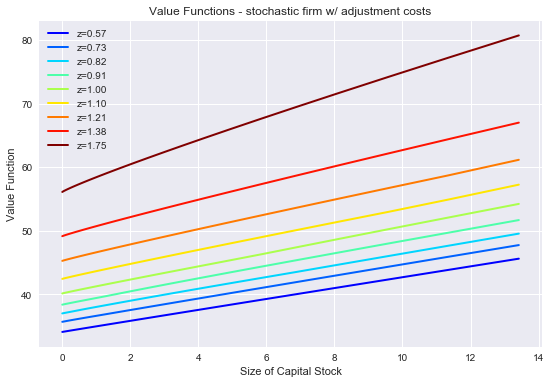

In [7]:
'''
------------------------------------------------------------------------
Find optimal capital and investment policy functions
------------------------------------------------------------------------
optK = (sizek,sizez) vector, optimal choice of k' for each k and z
optI = (sizek,sizez) vector, optimal choice of investment for each k and z
------------------------------------------------------------------------
'''
@jit
def optimal(kvec,PF,delta,sizez,optK=None):
    opt_vec = np.zeros((sizek,sizez))
    for k in range(sizez):
        if optK!=None:
            opt_vec[:,k] = optK[:,k]-(1-delta)*kvec
        else:
            opt_vec[:,k] = kvec[PF[:,k]]
            mask = (INV[:,k]==1)
            opt_vec[mask,k] = (1-delta)*kvec[mask]
    return opt_vec

optK_full = optimal(kvec,PF,delta,sizez)
optI_full = optimal(kvec,PF,delta,sizez,optK_full)

# Plot Value Function for each choice of capital stock and possible shocks
plt.subplots(figsize=(9, 6))
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(kvec, VF[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Functions - stochastic firm w/ adjustment costs')
plt.legend(loc='best')
plt.show()

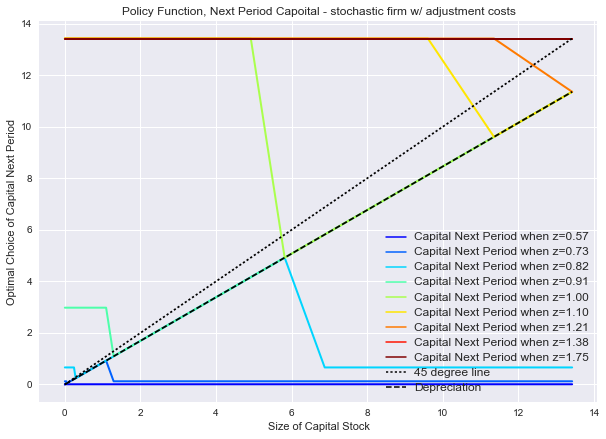

In [14]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(10,7))
for k in range(sizez):
    lb = 'Capital Next Period when z='+format(z_grid[k],'.2f')
    ax.plot(kvec, optK_full[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb,alpha=1)
ax.plot(kvec, kvec, 'k:', label='45 degree line')
ax.plot(kvec, (1-delta)*kvec, 'k--', label='Depreciation')
# Now add the legend with some customizations.
legend = ax.legend(loc='best', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - stochastic firm w/ ' +
          'adjustment costs')
plt.show()

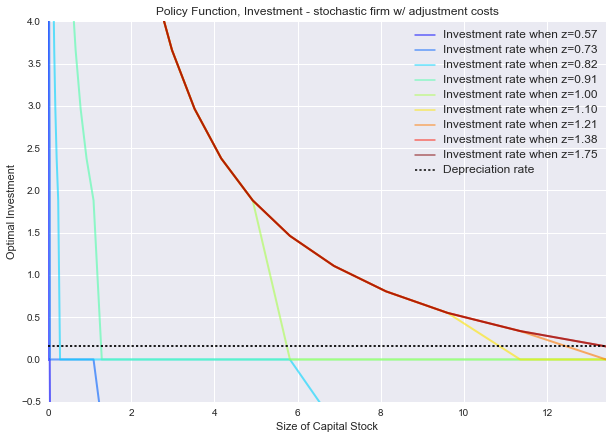

In [16]:
# Plot investment rule as a function of firm size
fig, ax = plt.subplots(figsize=(10,7))
for k in range(sizez):
    lb = 'Investment rate when z='+format(z_grid[k],'.2f')
    ax.plot(kvec, (optI_full[:,k]/kvec), color=plt.cm.jet((k+1)/sizez),lw=2,label=lb,alpha=0.6)
ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.axis([0,max(kvec),-0.5,4])
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.title('Policy Function, Investment - stochastic firm w/ adjustment ' +
          'costs')
plt.show()

Note that based on the policy function for capital and investment, when there is little capital, no matter the size of the productivity shock, the firms would invest a certain fixed amount for small sizes of capital stock since the cost is small. At a reservation capital stock, the investment becomes zero (thus capital follows the depreciation line). Then when the capital becomes even larger, it becomes more profitable to negatively invest (which we are allowing in this case, if not, then the investment will remain 0 as capital increases). Note that the investment becomes 0 at a lower size of capital when the firm is less productive.

### Approximate AR(1) Process

In [10]:
num_draws=sizek
# Simulate the Markov process - will make this a function so can call later
def sim_markov(z_grid, pi, num_draws):
    # draw some random numbers on [0, 1]
    u = np.random.uniform(size=num_draws)

    # Do simulations
    z_discrete = np.empty(num_draws)  # this will be a vector of values 
    # we land on in the discretized grid for z
    N = z_grid.shape[0]
    oldind = int(np.ceil((N - 1) / 2)) # set initial value to median of grid
    z_discrete[0] = z_grid[oldind]  
    for i in range(1, num_draws):
        sum_p = 0
        ind = 0
        while sum_p < u[i]:
            sum_p = sum_p + pi[ind, oldind]
            ind += 1
        if ind > 0:
            ind -= 1
        z_discrete[i] = z_grid[ind]
        oldind = ind            
    return z_discrete


# Call simulation function to get simulated values
z_discrete = sim_markov(z_grid, np.transpose(pi), num_draws)

# Find optimal capital and investment given the AR(1) process
@jit
def find_choice(optK_full,optI_full,VF,z_discrete,z_grid,sizek):
    opt_K = np.zeros(sizek)
    opt_I = np.zeros(sizek)
    VF_AR = np.zeros(sizek)
    for i in range(sizek): 
        ind = np.where(z_grid==z_discrete[i])[0]
        opt_K[i] = optK_full[i,ind]
        opt_I[i] = optI_full[i,ind]
        VF_AR[i] = VF[i,ind]
    return opt_K,opt_I, VF_AR

optK, optI, VFAR = find_choice(optK_full,optI_full,VF,z_discrete,z_grid,sizek)

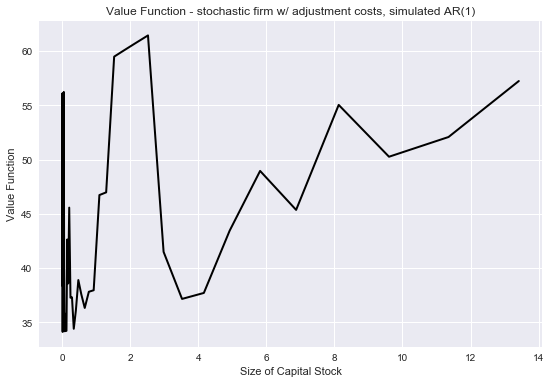

In [11]:
# Plot Value Function for a simulated AR(1)
plt.subplots(figsize=(9, 6))
plt.plot(kvec, VFAR, 'k-',lw=2)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - stochastic firm w/ adjustment costs, simulated AR(1)')
plt.show()

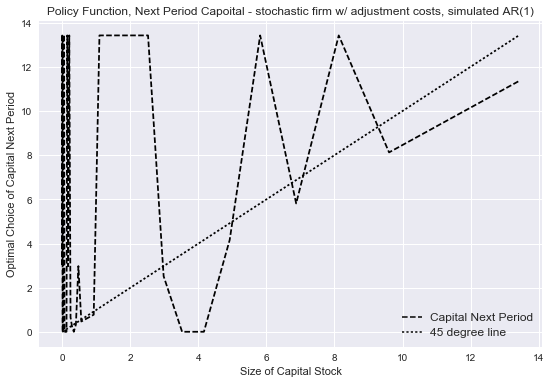

In [12]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(kvec, optK, 'k--', label='Capital Next Period')
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='best', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - stochastic firm w/ ' +
          'adjustment costs, simulated AR(1)')
plt.show()

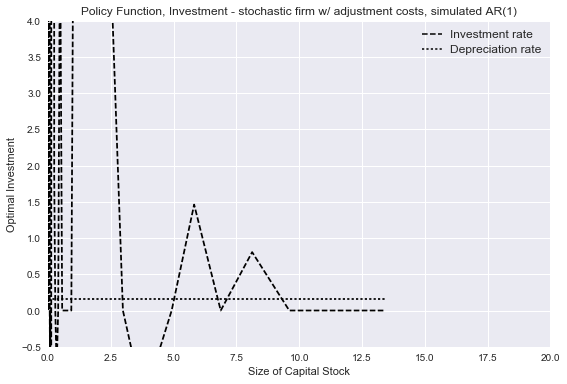

In [13]:
# Plot investment rule as a function of firm size
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(kvec, (optI/kvec), 'k--', label='Investment rate')
ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='best', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.axis([0,20,-0.5,4])
plt.ylabel('Optimal Investment')
plt.title('Policy Function, Investment - stochastic firm w/ adjustment ' +
          'costs, simulated AR(1)')
plt.show()